In [45]:
# Install python modules
!pip install

  Using cached harmony-1.2.4098.tar.gz (254 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached antlr_denter-1.3.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached antlr4_python3_runtime-4.9.3-py3-none-any.whl
  Using cached automata_lib-9.1.2-py3-none-any.whl.metadata (4.9 kB)
  Using cached pydot-4.0.1-py3-none-any.whl.metadata (11 kB)
  Using cached frozendict-2.4.6-py312-none-any.whl.metadata (23 kB)
  Using cached cached_method-0.1.0-py3-none-any.whl.metadata (2.9 kB)
Using cached antlr_denter-1.3.1-py3-none-any.whl (5.1 kB)
Using cached automata_lib-9.1.2-py3-none-any.whl (80 kB)
Using cached cached_method-0.1.0-py3-none-any.whl (4.2 kB)
Using cached frozendict-2.4.6-py312-none-any.whl (

  error: subprocess-exited-with-error
  
  exit code: 1
  
  [198 lines of output]
  running bdist_wheel
  running build
  running build_py
  creating build\lib.win-amd64-cpython-312\harmony_model_checker
  copying harmony_model_checker\compile.py -> build\lib.win-amd64-cpython-312\harmony_model_checker
  copying harmony_model_checker\config.py -> build\lib.win-amd64-cpython-312\harmony_model_checker
  copying harmony_model_checker\dfacmp.py -> build\lib.win-amd64-cpython-312\harmony_model_checker
  copying harmony_model_checker\exception.py -> build\lib.win-amd64-cpython-312\harmony_model_checker
  copying harmony_model_checker\iface.py -> build\lib.win-amd64-cpython-312\harmony_model_checker
  copying harmony_model_checker\main.py -> build\lib.win-amd64-cpython-312\harmony_model_checker
  copying harmony_model_checker\__init__.py -> build\lib.win-amd64-cpython-312\harmony_model_checker
  creating build\lib.win-amd64-cpython-312\tests
  copying tests\test_h2py.py -> build\lib.win-amd6

In [44]:
# Import python modules
from glob import glob
import numpy as np
import pandas as pd
import earthaccess
import geopandas as gpd
import requests as re
import s3fs
import h5py
from os import path
from datetime import datetime
from shapely.ops import orient
from shapely.geometry import Polygon, MultiPolygon
import matplotlib.pyplot as plt
from shapely.geometry import box
import dask.dataframe as dd
from urllib import request, parse
from http.cookiejar import CookieJar
from base64 import b64encode
import getpass
import netrc
import requests
import json
import pprint
from osgeo import gdal
import matplotlib.image as mpimg
import rasterio
from rasterio.plot import show
import time
from netCDF4 import Dataset
from owslib.wms import WebMapService
from owslib.util import Authentication
%matplotlib inline
from harmony import BBox,Client, Collection, Request, LinkType

ModuleNotFoundError: No module named 'harmony'

In [5]:
def convert_umm_geometry(gpoly):
    """converts UMM geometry to multipolygons"""
    multipolygons = []
    for gl in gpoly:
        ltln = gl["Boundary"]["Points"]
        points = [(p["Longitude"], p["Latitude"]) for p in ltln]
        multipolygons.append(Polygon(points))
    return MultiPolygon(multipolygons)

def convert_list_gdf(datag):
    """converts List[] to geopandas dataframe"""
    # create pandas dataframe from json
    df = pd.json_normalize([vars(granule)['render_dict'] for granule in datag])
    # keep only last string of the column names
    df.columns=df.columns.str.split('.').str[-1]
    # convert polygons to multipolygonal geometry
    df["geometry"] = df["GPolygons"].apply(convert_umm_geometry)
    # return geopandas dataframe
    return gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

In [6]:
# esri background basemap for maps
xyz = "https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}"
attr = "ESRI"

In [7]:
# Find out how many L1B files from the BioSCape Campaign are published on NASA Earthdata.
doi="10.5067/XQJ8PN8FTIDG" # LVIS L1B doi
query = earthaccess.DataGranules().doi(doi)
query.params['campaign'] = 'bioscape'
l1b = query.get_all()
print(f'Granules found: {len(l1b)}')

Granules found: 2328


In [8]:
# Are they hosted on Earthdata cloud or not
def get_granule_index(granules, dts):
    """returns granule index matching timestamp"""
    for index, val in enumerate(l1b):
        if f'_{dts}' in val.data_links()[0]:
            return index
# index of granule with R2404_034819 datetime stamp (Rhodes Memorial granule)
i = get_granule_index(l1b, 'R2404_034819')
l1b[i]

Collection: {'EntryTitle': 'LVIS Facility L1B Geolocated Return Energy Waveforms V001'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': 18.44703, 'Latitude': -33.87154}, {'Longitude': 18.44706, 'Latitude': -33.87513}, {'Longitude': 18.44724, 'Latitude': -33.90382}, {'Longitude': 18.44757, 'Latitude': -33.99349}, {'Longitude': 18.46481, 'Latitude': -34.00425}, {'Longitude': 18.46894, 'Latitude': -33.95044}, {'Longitude': 18.46846, 'Latitude': -33.87154}, {'Longitude': 18.447, 'Latitude': -33.86795}, {'Longitude': 18.44703, 'Latitude': -33.87154}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2023-11-13T09:40:19.398Z', 'EndingDateTime': '2023-11-13T09:41:55.993Z'}}
Size(MB): 921.264
Data: ['https://n5eil01u.ecs.nsidc.org/DP6/ICEBRIDGE/LVISF1B.001/2023.11.13/LVISF1B_BioSCape2023_1113_R2404_034819.h5']

In [9]:
# Cloud hosted: False means that the file is not cloud hosted yet. It has to be downloaded locally and use it.
# I will go ahead and use earthaccess python module to get the file directly and save it to the downloads directory

In [10]:
# download files
downloaded_files = earthaccess.download(l1b[i], local_path="downloads")

QUEUEING TASKS | : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]
PROCESSING TASKS | : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]
COLLECTING RESULTS | : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


In [11]:
# Open LVISF1B_BioSCape2023_1113_R2404_034819.h5 and look at its structure
l1b_i= f'downloads/{path.basename(l1b[i].data_links()[0])}'
with h5py.File(l1b_i) as hf:
    for v in list(hf.keys()):
        if v != "ancillary_data":
            print(f"- {v} : {hf[v].attrs['description'][0].decode('utf-8')}")

- AZIMUTH : Azimuth angle of laser beam
- INCIDENTANGLE : Off-nadir incident angle of laser beam
- LAT0 : Latitude of the highest sample of the return waveform (degrees north) 
- LAT1215 : Latitude of the lowest sample of the return waveform (degrees north) 
- LFID : LVIS file identification.  Together with 'LVIS shotnumber' these are a unique identifier for every LVIS laser shot. Format is XXYYYYYZZZ where XX identifies instrument version, YYYYY is the Modified Julian Date of the flight departure day, ZZZ represents file number.
- LON0 : Longitude of the highest sample of the return waveform (degrees east)
- LON1215 : Longitude of the lowest sample of the return waveform (degrees east) 
- RANGE : Distance along laser path from the instrument to the ground
- RXWAVE : Returned waveform (1216 samples long)
- SHOTNUMBER : Laser shot number assigned during collection.  Together with 'LVIS LFID' provides a unique identifier to every LVIS laser shot.
- SIGMEAN : Signal mean noise level, calc

In [12]:
with h5py.File(l1b_i) as hf:
    l_lat = hf['LAT1215'][:]
    l_lon = hf['LON1215'][:]
    l_range = hf['Z1215'][:] # ground elevation
    shot = hf['SHOTNUMBER'][:] # ground elevation
geo_arr = list(zip(shot, l_range,l_lat,l_lon))
l1b_df = pd.DataFrame(geo_arr, columns=["shot_number", "elevation", "lat", "lon"])
l1b_df

,shot_number,elevation,lat,lon
0,7605355,71.897652,-33.997367,18.456976
1,7605356,70.482124,-33.997416,18.457046
2,7605357,71.480583,-33.997362,18.457042
3,7605358,70.971931,-33.997412,18.457111
4,7605359,69.389961,-33.997357,18.457106
...,...,...,...,...
349995,7991726,-9.602999,-33.871817,18.462105
349996,7991727,-10.162307,-33.871867,18.462176
349997,7991728,-9.202106,-33.871813,18.462171
349998,7991729,-10.013672,-33.871863,18.462243


In [13]:
l1b_gdf = gpd.GeoDataFrame(l1b_df[['shot_number', 'elevation']], crs="EPSG:4326",
                           geometry=gpd.points_from_xy(l1b_df.lon, 
                                                       l1b_df.lat))
m = l1b_gdf.sample(frac=0.01).explore("elevation", cmap = "plasma", tiles=xyz, attr=attr)
# plot a single shot as red
i = np.where(shot==7748487)[0][0]
l1b_gdf.iloc[[i]].explore(m=m, marker_type="marker")
m

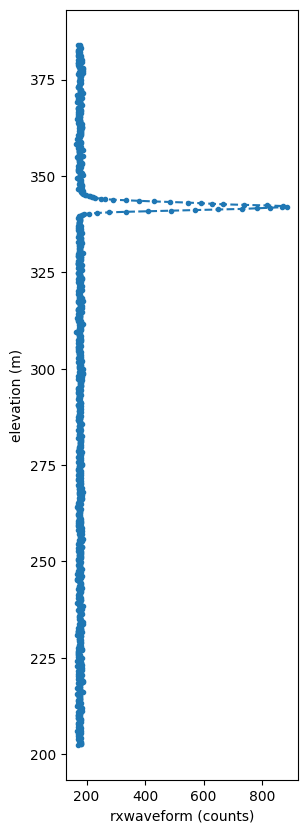

In [14]:
# Look at the waveform structure at that shot_number/point
with h5py.File(l1b_i) as hf:
    rxwaveform = hf['RXWAVE'][i, :] # waveform
    elev_1215 = hf['Z1215'][i] # elevation ground
    elev_0 = hf['Z0'][i] # elevation top
c = len(rxwaveform) #
elev = np.linspace(elev_1215, elev_0, num=c)
# plot
plt.rcParams["figure.figsize"] = (3,10)
plt.xlabel("rxwaveform (counts)")
plt.ylabel("elevation (m)")
plt.plot(rxwaveform, elev, linestyle='--', marker='.',)

In [15]:
# Structure of LVIS L2 Canopy Height Product --->

In [16]:
# Search how many L2 files are there for the BioSCape campaign dates
doi="10.5067/VP7J20HJQISD" # LVIS L2 doi
query = earthaccess.DataGranules().doi(doi)
query.params['campaign'] = 'bioscape'
l2 = query.get_all()
print(f'Granules found: {len(l2)}')

Granules found: 2328


In [17]:
# Check to see if they are hosted on Earthdata cloud or not, by printing a summary of the first granule
# index of granule with R2404_041222 datetime stamp
i = get_granule_index(l2, 'R2404_034819')
l2[i]

Collection: {'EntryTitle': 'LVIS Facility L2 Geolocated Surface Elevation and Canopy Height Product V001'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': 18.44703, 'Latitude': -33.87154}, {'Longitude': 18.44706, 'Latitude': -33.87513}, {'Longitude': 18.44724, 'Latitude': -33.90382}, {'Longitude': 18.44757, 'Latitude': -33.99349}, {'Longitude': 18.46481, 'Latitude': -34.00425}, {'Longitude': 18.46896, 'Latitude': -33.96121}, {'Longitude': 18.46846, 'Latitude': -33.87154}, {'Longitude': 18.447, 'Latitude': -33.86795}, {'Longitude': 18.44703, 'Latitude': -33.87154}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2023-11-13T09:40:19.398Z', 'EndingDateTime': '2023-11-13T09:41:55.993Z'}}
Size(MB): 128.175
Data: ['https://n5eil01u.ecs.nsidc.org/DP6/ICEBRIDGE/LVISF2.001/2023.11.13/LVISF2_BioSCape2023_1113_R2404_034819.TXT']

In [18]:
# As we see above, the LVIS files are not cloud-hosted yet. They have to be downloaded locally and use them. We will go ahead and use earthaccess 
# python module to get the file directly and save it to the downloads directory.

In [19]:
# download files
downloaded_files = earthaccess.download(l2[i], local_path="downloads")

QUEUEING TASKS | : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]
PROCESSING TASKS | : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1001.51it/s]
COLLECTING RESULTS | : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


In [20]:
# Open a file to look at it’s structure
l2_i = f'downloads/{path.basename(l2[i].data_links()[0])}'
with open(l2_i, 'r') as f:
    # print first 15 rows
    head = [next(f) for _ in range(15)]
    print(head)

["# Level2 (v2.0.5) data set collected by NASA's Land, Vegetation and Ice Sensor (LVIS) Facility in October-November 2023 as part of NASA's BioSCape Field Campaign. This file contains elevation,\n", "# height and surface structure metrics derived from LVIS's geolocated laser return waveform. The corresponding spatially geolocated laser return waveforms are contained in the Level 1B data set.\n", '# For supporting information please visit https://lvis.gsfc.nasa.gov/Data/Maps/SouthAfrica2023Map.html. LVIS-targeted data collections occurred at flight altitudes of ~7 km above the surface from\n', '# the NASA G-V, however data collections also occurred at lower altitudes. The "Range" parameter can be used to determine flight altitude. Note: Two alternate ground elevations options are provided\n', '# in order to provide flexibility for local site conditions; if selected for use, adjust the values of the RH parameters accordingly. Please consult the User Guide for further information. The dat

In [21]:
# Define a python function to read the number of header rows.
def get_line_number(filename):
    """find number of header rows in LVIS L2A"""
    count = 0
    with open(filename, 'r') as f:
        for line in f:
            if line.startswith('#'):
                count = count + 1
                columns = line[1:].split()
            else:
                return count, columns

In [22]:
h_no, col_names = get_line_number(l2_i)
with open(l2_i, 'r') as f:
    l2a_df = pd.read_csv(f, skiprows=h_no, header=None, engine='python', sep=r'\s+')
    l2a_df.columns =  col_names
l2a_df

,LFID,SHOTNUMBER,TIME,GLON,GLAT,ZG,ZG_ALT1,ZG_ALT2,HLON,HLAT,...,RH99,RH100,AZIMUTH,INCIDENTANGLE,RANGE,COMPLEXITY,SENSITIVITY,CHANNEL_ZT,CHANNEL_ZG,CHANNEL_RH
0,1960261064,7605355,34819.39822,18.457003,-33.997388,112.82,112.82,112.82,18.457011,-33.997393,...,11.54,12.10,313.11,4.777,5384.46,0.442,0.973,2,2,2
1,1960261064,7605356,34819.39847,18.457075,-33.997438,115.03,115.03,115.03,18.457082,-33.997444,...,13.93,15.08,313.15,4.688,5380.41,0.404,0.996,1,1,1
2,1960261064,7605357,34819.39872,18.457068,-33.997383,112.51,112.51,112.51,18.457072,-33.997386,...,5.64,6.20,313.67,4.734,5381.76,0.381,0.952,2,2,2
3,1960261064,7605358,34819.39897,18.457141,-33.997435,118.25,118.25,118.25,18.457147,-33.997440,...,11.28,12.06,313.73,4.645,5378.17,0.377,0.997,1,1,1
4,1960261064,7605359,34819.39922,18.457133,-33.997379,112.37,112.37,112.37,18.457143,-33.997387,...,12.40,16.35,314.25,4.691,5381.32,0.406,0.996,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349995,1960261067,7991726,34915.99205,18.462069,-33.871840,31.05,31.05,31.05,18.462069,-33.871840,...,0.82,1.16,52.41,5.957,5469.55,0.114,0.957,1,1,1
349996,1960261067,7991727,34915.99230,18.462139,-33.871891,30.94,30.94,30.94,18.462139,-33.871891,...,0.82,1.16,53.25,5.976,5470.44,0.089,0.957,1,1,1
349997,1960261067,7991728,34915.99255,18.462135,-33.871836,31.11,31.11,31.11,18.462135,-33.871836,...,0.75,1.04,52.75,6.010,5469.84,0.088,0.957,1,1,1
349998,1960261067,7991729,34915.99280,18.462205,-33.871887,31.12,31.12,31.12,18.462205,-33.871887,...,0.75,1.08,53.59,6.029,5470.44,0.088,0.961,1,1,1


In [23]:
# Print LVIS L2 variable names.
l2a_df.columns.values

array(['LFID', 'SHOTNUMBER', 'TIME', 'GLON', 'GLAT', 'ZG', 'ZG_ALT1',
       'ZG_ALT2', 'HLON', 'HLAT', 'ZH', 'TLON', 'TLAT', 'ZT', 'RH10',
       'RH15', 'RH20', 'RH25', 'RH30', 'RH35', 'RH40', 'RH45', 'RH50',
       'RH55', 'RH60', 'RH65', 'RH70', 'RH75', 'RH80', 'RH85', 'RH90',
       'RH95', 'RH96', 'RH97', 'RH98', 'RH99', 'RH100', 'AZIMUTH',
       'INCIDENTANGLE', 'RANGE', 'COMPLEXITY', 'SENSITIVITY',
       'CHANNEL_ZT', 'CHANNEL_ZG', 'CHANNEL_RH'], dtype=object)

In [24]:
# The GLAT and GLON variables provide coordinates of the lowest detected mode within the LVIS waveform.
# The RHXX variables provide height above the lowest detected mode at which XX percentile of the waveform energy.
# RANGE provides the distance from the instrument to the ground.
# SENSITIVITY provides sensitivity metric for the return waveform.
# ZG,ZG_ALT1, ZG_ALT2: Mean elevation of the lowest detected mode using alternate 1/2 mode detection settings.
# The alternative ZG to use to adjust the RH parameters for local site conditions.

In [25]:
# Select the particular shot we are interested in.
l2a_shot_df = l2a_df[l2a_df['SHOTNUMBER'] == 7748487]
l2a_shot_df

,LFID,SHOTNUMBER,TIME,GLON,GLAT,ZG,ZG_ALT1,ZG_ALT2,HLON,HLAT,...,RH99,RH100,AZIMUTH,INCIDENTANGLE,RANGE,COMPLEXITY,SENSITIVITY,CHANNEL_ZT,CHANNEL_ZG,CHANNEL_RH
141606,1960261065,7748487,34855.18162,18.456488,-33.951438,244.5,244.5,244.5,18.456488,-33.951438,...,1.53,2.02,315.85,4.082,5242.87,0.376,0.979,2,2,2


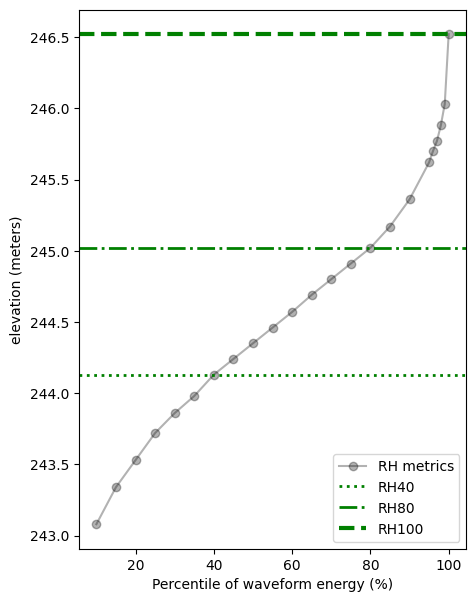

In [26]:
# Plot the RH metrics with elevation.
elev_zg = l2a_shot_df.ZG.values[0]
elev_zh = l2a_shot_df.ZH.values[0]
rh40 = l2a_shot_df.RH40.values[0]
rh80 = l2a_shot_df.RH80.values[0]
rh100 = l2a_shot_df.RH100.values[0]
rh = l2a_shot_df.filter(like ='RH').drop('CHANNEL_RH', axis=1).values.tolist()[0]

# plotting
plt.rcParams["figure.figsize"] = (5,7)
rh_vals = l2a_shot_df.filter(like = 'RH').columns[:-1].str.strip('RH').astype(int).tolist()
fig, ax1 = plt.subplots()
ax1.plot(rh_vals, elev_zg+rh, alpha=0.3, marker='o', color='black', label='RH metrics' )
ax1.axhline(y=elev_zg+rh40,  color='g', linestyle='dotted', linewidth=2, label='RH40')
ax1.axhline(y=elev_zg+rh80,  color='g', linestyle='-.', linewidth=2, label='RH80')
ax1.axhline(y=elev_zg+rh100,  color='g', linestyle='--', linewidth=3, label='RH100')
ax1.set_xlabel("Percentile of waveform energy (%)")
ax1.set_ylabel("elevation (meters)")
ax1.legend(loc="lower right")
plt.show()

In [27]:
# Plot LVIS Bioscape Campaigns

In [28]:
#  Define two functions that we can use to plot the search results above over a basemap.
def convert_umm_geometry(gpoly):
    """converts UMM geometry to multipolygons"""
    multipolygons = []
    for gl in gpoly:
        ltln = gl["Boundary"]["Points"]
        points = [(p["Longitude"], p["Latitude"]) for p in ltln]
        multipolygons.append(Polygon(points))
    return MultiPolygon(multipolygons)

def convert_list_gdf(datag):
    """converts List[] to geopandas dataframe"""
    # create pandas dataframe from json
    df = pd.json_normalize([vars(granule)['render_dict'] for granule in datag])
    # keep only last string of the column names
    df.columns=df.columns.str.split('.').str[-1]
    # convert polygons to multipolygonal geometry
    df["geometry"] = df["GPolygons"].apply(convert_umm_geometry)
    # return geopandas dataframe
    return gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

In [29]:
# Convert the JSON return from the earthaccess granule search into a geopandas dataframe so we could plot over an ESRI basemap.
gdf = convert_list_gdf(l2)
#plot
gdf[['BeginningDateTime','geometry']].explore(tiles=xyz, attr=attr)

In [30]:
# The above shows the flight lines of all LVIS collection during the BioSCape campaign in 2023.

In [31]:
# Search LVIS L2A granules over a study area
poly_f = "data/Plot/Rhodes_plot.geojson"
poly = gpd.read_file(poly_f)
poly.explore(tiles=xyz, attr=attr, style_kwds={'color':'red', 'fill':False})

In [32]:
# Search for LVIS L2A granules that are within the bounds of the study area.
poly.geometry = poly.geometry.apply(orient, args=(1,))
# simplifying the polygon to bypass the coordinates 
# limit of the CMR with a tolerance of .005 degrees
xy = poly.geometry.simplify(0.005).get_coordinates()

l2_poly = earthaccess.search_data(
    count=-1, # needed to retrieve all granules
    doi="10.5067/VP7J20HJQISD", # LVIS L2A doi
    temporal=("2023-10-01", "2023-11-30"), # Bioscape campaign dates
    polygon=list(zip(xy.x, xy.y))
)
print(f'Granules found: {len(l2_poly)}')

Granules found: 6


In [33]:
# Plot these six flight lines over a basemap.
gdf = convert_list_gdf(l2_poly)
m = gdf[['BeginningDateTime','geometry']].explore(tiles=xyz, attr=attr, 
                                              style_kwds={'fillOpacity':0.1})
m

In [34]:
# Download L2 granules
downloaded_files = earthaccess.download(l2_poly, local_path="lvis")

QUEUEING TASKS | : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 187.66it/s]
PROCESSING TASKS | : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 6017.65it/s]
COLLECTING RESULTS | : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<?, ?it/s]


In [36]:
# Read LVIS L2A Files
# get header rows and column names
h_no, col_names = get_line_number(downloaded_files[0])
# read the LVIS L2A files
ddf = dd.read_csv(downloaded_files, skiprows=h_no, names=col_names,
                  header=None, sep=r'\s+') 
# dask to pandas dataframe
df = ddf.compute()
# converting to geopandas
lvis_l2a_gdf = gpd.GeoDataFrame(df, 
                                geometry=gpd.points_from_xy(df.GLON, 
                                                            df.GLAT),
                                crs="EPSG:4326")
# clipping LVIS by polygon
lvis_l2a_gdf = gpd.sjoin(lvis_l2a_gdf, poly, predicate='within')

In [37]:
# Plot RH100 (height of top canopy) values in a map.
lvis_l2a_gdf[['RH100', 'geometry']].sample(frac=0.1, random_state=1).explore(
    "RH100", cmap = "YlGn", tiles=xyz, attr=attr, alpha=0.5, radius=10, legend=True)

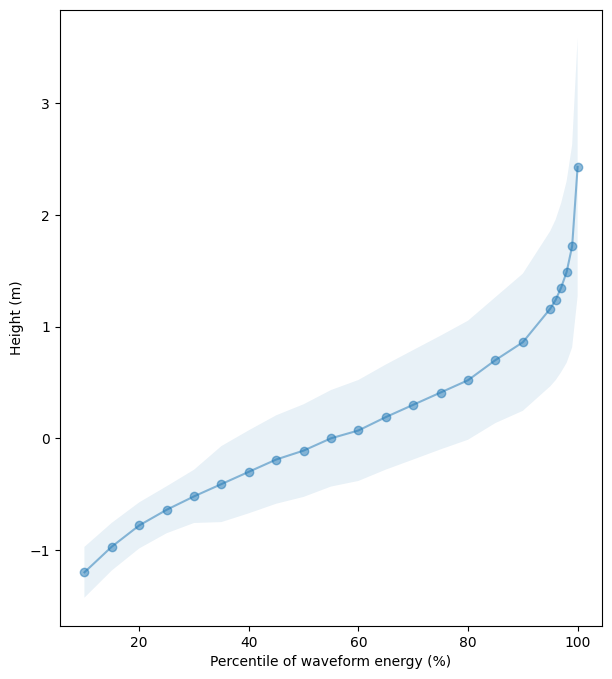

In [38]:
# Relative Height Distribution
# Generate a plot of RH metrics to check if the vegetation height across the percentile of waveform energy indicates the same
fig, ax = plt.subplots(figsize=(7, 8))
plot_df = lvis_l2a_gdf.sample(frac=0.1, random_state=1).filter(like='RH').drop('CHANNEL_RH', axis=1).T
plot_df.index = plot_df.index.str.strip('RH').astype(int)
std_df = plot_df.std(axis=1)
median_df = plot_df.median(axis=1)
median_df.plot(ax=ax, alpha=0.5, style='o-')
ax.fill_between(plot_df.index, median_df - std_df, median_df + std_df, alpha=0.1)
ax.set_xlabel("Percentile of waveform energy (%)")
ax.set_ylabel("Height (m)")
plt.show()

In [ ]:
# GEDI L2A Canopy Height Metrics

In [ ]:
# Use NASA’s Harmony Services to retrieve the GEDI L2A dataset and canopy heights (RH100)

# The GEDI Level 2A Geolocated Elevation and Height Metrics product GEDI02_A provides waveform interpretation and extracted 
# products from eachreceived waveform, including ground elevation, canopy top height, and relative height (RH) metrics

In [43]:
harmony_client = Client(auth=("phemelo_rutlokoane", "@Pr0209255246081"))

NameError: name 'Client' is not defined